In [141]:
import pandas as pd

In [142]:
df = pd.read_csv('dataset.csv', encoding='windows-1252')
print(df.head())
print(df.info())

  Order Date  Row ID        Order ID       Ship Mode Customer ID      Segment  \
0   01-01-20     849  CA-2017-107503  Standard Class    GA-14725     Consumer   
1   01-01-20    4010  CA-2017-144463  Standard Class    SC-20725     Consumer   
2   01-01-20    6683  CA-2017-154466     First Class    DP-13390  Home Office   
3   01-01-20    8070  CA-2017-151750  Standard Class    JM-15250     Consumer   
4   01-01-20    8071  CA-2017-151750  Standard Class    JM-15250     Consumer   

         Country         City       State  Postal Code   Region  \
0  United States       Lorain        Ohio        44052     East   
1  United States  Los Angeles  California        90036     West   
2  United States     Franklin   Wisconsin        53132  Central   
3  United States   Huntsville       Texas        77340  Central   
4  United States   Huntsville       Texas        77340  Central   

        Product ID         Category Sub-Category  \
0  FUR-FU-10003878        Furniture  Furnishings   
1  FUR

In [143]:
df.describe()
df.drop(['Country'], axis = 1, inplace=True)

In [144]:
m = df['Profit'].mean()
std = df['Profit'].std()
# df = df[(df['Profit'] <= m + 3 * std) & (df['Profit'] >= m - 3 * std)]
# df = df[df['Segment'] == 'Consumer']

<Axes: ylabel='Frequency'>

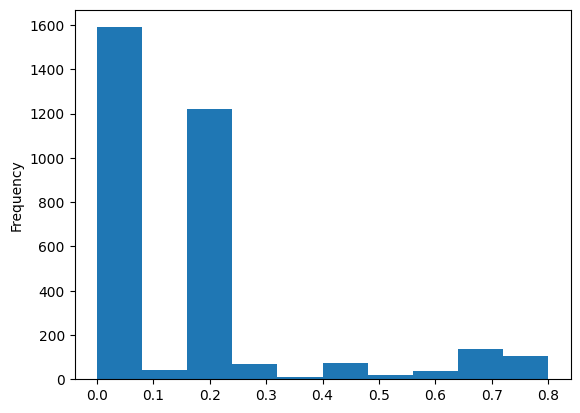

In [145]:
df['Discount'].plot(kind='hist')

In [146]:
def compare_profit(df, discounted):
    combined_profit_with_discount = discounted['Profit'].sum()
    combined_profit_without_discount = df[df['Discount'] == 0]['Profit'].sum()
    
    average_profit_with_discount = discounted['Profit'].mean()
    average_profit_without_discount = df[df['Discount'] == 0]['Profit'].mean()
    
    print("Combined Profit:")
    print(f"With Discount: {combined_profit_with_discount}")
    print(f"Without Discount: {combined_profit_without_discount}")
    
    print("\nAverage Profit:")
    print(f"With Discount: {average_profit_with_discount}")
    print(f"Without Discount: {average_profit_without_discount}")

In [147]:
compare_profit(df, df)
compare_profit(df, df[df['Discount'].between(0.0, 0.3, inclusive='both')])

Combined Profit:
With Discount: 93439.2696
Without Discount: 104157.71220000001

Average Profit:
With Discount: 28.212339855072464
Without Discount: 65.50799509433963
Combined Profit:
With Discount: 137141.5672
Without Discount: 104157.71220000001

Average Profit:
With Discount: 46.88600588034188
Without Discount: 65.50799509433963


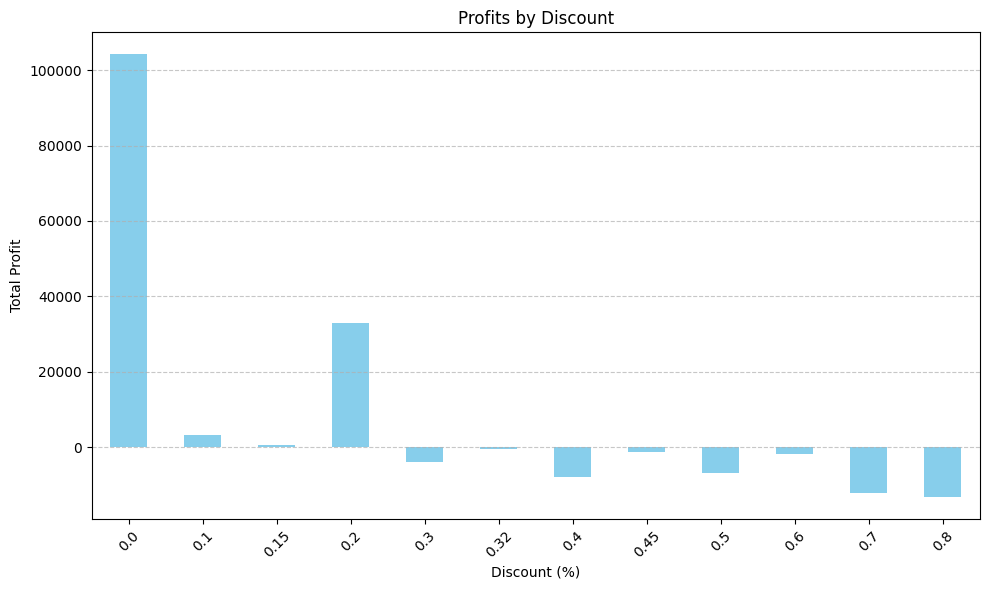

In [148]:
import matplotlib.pyplot as plt
profits_by_discount = df.groupby('Discount')['Profit'].sum()

plt.figure(figsize=(10, 6))
profits_by_discount.plot(kind='bar', color='skyblue')
plt.title('Profits by Discount')
plt.xlabel('Discount (%)')
plt.ylabel('Total Profit')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [149]:
df = df[df['Discount'] <= 0.4] # Discounts over 40% have never yielded profits

In [180]:
customer_behaviors = pd.DataFrame()
for segment in df['Segment'].unique():
    seg = df[df['Segment'] == segment]
    print(segment)
    for col in df['Sub-Category'].unique():
        cat = seg[seg['Sub-Category'] == col]
        for ind, row in cat.iterrows():
            rowid = row['Row ID']
            client = row['Customer ID']
            prev_purch = cat.iloc[:rowid]
            prev_purch = prev_purch[prev_purch['Customer ID'] == client]
            if prev_purch.empty:
                break
            purch_count = len(prev_purch['Order ID'].unique())
            prev_purch = prev_purch.drop(['Order Date', 'Order ID', 'Row ID', 'City', 'Postal Code', 'Product ID', 'Category', 'Product Name'], axis=1)
            mode = lambda x: x.value_counts().index[0]
            customer = prev_purch.agg({'Ship Mode': mode, 'Segment': mode, 'State': mode, 'Region': mode, 'Sub-Category': mode, 'Sales': 'mean', 'Quantity': 'mean', 'Discount': 'mean', 'Profit': 'mean'})
            customer = pd.DataFrame(data=customer).transpose().add_prefix('cust_')
            customer['cust_Orders'] = purch_count
            row = row.drop(['Order Date', 'Order ID', 'Row ID', 'City', 'Postal Code', 'Product ID', 'Category', 'Product Name'])
            row = pd.DataFrame(row).transpose().add_prefix('next_').reset_index()
            #print("row:")
            #print(row)
            customer = pd.concat([customer, row], axis=1)
            #print("customer:")
            #print(customer)
            customer_behaviors = pd.concat([customer_behaviors , customer], ignore_index=True)
        
    print(customer_behaviors.head(10))

Consumer
   cust_Ship Mode cust_Segment    cust_State cust_Region cust_Sub-Category  \
0  Standard Class     Consumer          Ohio        East       Furnishings   
1  Standard Class     Consumer    California        West       Furnishings   
2    Second Class     Consumer  Pennsylvania        East       Furnishings   
3  Standard Class     Consumer       Georgia       South       Furnishings   
4    Second Class     Consumer          Iowa     Central       Furnishings   
5  Standard Class     Consumer    California        West       Furnishings   
6     First Class     Consumer          Ohio        East       Furnishings   
7  Standard Class     Consumer    Washington        West       Furnishings   
8  Standard Class     Consumer    California        West       Furnishings   
9    Second Class     Consumer      New York        East       Furnishings   

  cust_Sales cust_Quantity cust_Discount cust_Profit  cust_Orders  ...  \
0     48.896           4.0           0.2      8.5568      

In [181]:
customer_behaviors.head(10)
customer_behaviors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   cust_Ship Mode     2603 non-null   object
 1   cust_Segment       2603 non-null   object
 2   cust_State         2603 non-null   object
 3   cust_Region        2603 non-null   object
 4   cust_Sub-Category  2603 non-null   object
 5   cust_Sales         2603 non-null   object
 6   cust_Quantity      2603 non-null   object
 7   cust_Discount      2603 non-null   object
 8   cust_Profit        2603 non-null   object
 9   cust_Orders        2603 non-null   int64 
 10  index              2603 non-null   int64 
 11  next_Ship Mode     2603 non-null   object
 12  next_Customer ID   2603 non-null   object
 13  next_Segment       2603 non-null   object
 14  next_State         2603 non-null   object
 15  next_Region        2603 non-null   object
 16  next_Sub-Category  2603 non-null   object


In [187]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

categorical_columns = customer_behaviors.select_dtypes(include=['object']).columns.tolist()
numerical_columns = customer_behaviors.select_dtypes(include=['float64', 'int64']).columns.tolist()

X = customer_behaviors[categorical_columns + numerical_columns]
#X = X[customer_behaviors['cust_Segment']=='Consumer']
y = customer_behaviors['next_Discount']
#y = y[customer_behaviors['cust_Segment']=='Consumer']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('poly', PolynomialFeatures(degree=2)),
                           ('regressor', ElasticNet())])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
y_pred_train = pipeline.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error:", mse)
# Calculate percentage error for each prediction
percentage_errors = (((y_test + 1) - (y_pred + 1)) / (y_test + 1)) * 100
#percentage_errors = (((y_test ) - (y_pred )) / (y_test )) * 100
mean_percentage_error = np.mean(percentage_errors)
print("Mean Percentage Error:", mean_percentage_error)
#percentage_errors = (((y_train ) - (y_pred_train )) / (y_train )) * 100
mean_percentage_error = np.mean(percentage_errors)
print("Mean Percentage Error:", mean_percentage_error)

# Calculate mean percentage error

Mean Squared Error: 0.01360673500214359
Mean Squared Error: 0.0123966330497628
Mean Percentage Error: -0.2932167888870433
Mean Percentage Error: -0.2932167888870433
